<a href="https://colab.research.google.com/github/Avani1994/NLP/blob/main/FITNetsImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm.auto import tqdm

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Setup training data
train_data = datasets.MNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.MNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [ ]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
image.shape

torch.Size([1, 28, 28])

In [ ]:
# How many samples are there?
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)


(60000, 60000, 10000, 10000)

In [ ]:
# See classes
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Image shape: torch.Size([1, 28, 28])


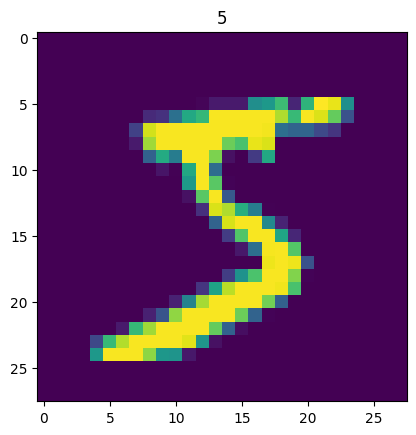

In [ ]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1,2,0)) #or image.squeeze() # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label);

In [ ]:
image.dtype

torch.float32

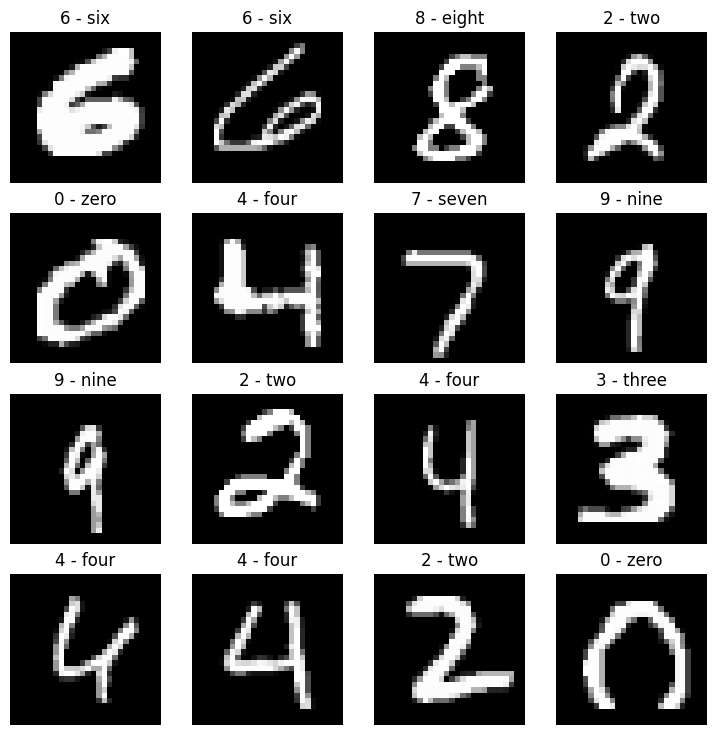

In [ ]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

# Data Loader

In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x799a904e7c70>, <torch.utils.data.dataloader.DataLoader object at 0x799a908d1fc0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [ ]:
train_feature_batch,train_label_batch = next(iter(train_dataloader))

In [ ]:
train_feature_batch.shape, train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Text(0.5, 1.0, 'tensor(9)')

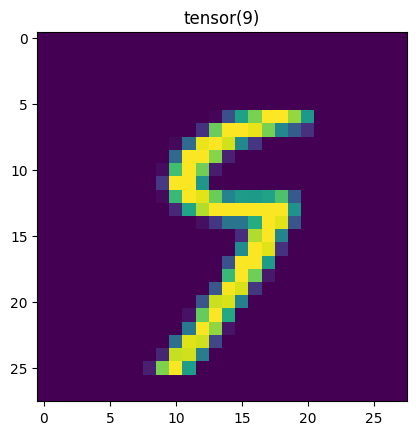

In [ ]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_feature_batch), size = [1]).item()
img, label = train_feature_batch[random_idx], train_label_batch[random_idx]
plt.imshow(img.permute(1, 2, 0))
plt.title(label)

# Baseline Model



In [ ]:
class BaseModel(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_shape, hidden_units),
        nn.Linear(hidden_units, output_shape))

  def forward(self, x):
    x = self.classifier(x)
    return x


In [ ]:
torch.manual_seed(42)
model = BaseModel(input_shape=784, hidden_units=10, output_shape=len(class_names))
model

BaseModel(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
train_feature_batch[0].shape

torch.Size([1, 28, 28])

In [ ]:
train_feature_batch[0].unsqueeze(dim=2).shape

torch.Size([1, 28, 1, 28])

In [ ]:
model(train_feature_batch[0].unsqueeze(dim=0))

tensor([[ 0.0452,  0.3760,  0.1961, -0.1388,  0.2898,  0.2163,  0.1938,  0.2665,
         -0.2593, -0.1660]], grad_fn=<AddmmBackward0>)

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
BaseModel                                --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       7,850
│    └─Linear: 2-3                       110
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0

Loss and Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.1)

In [ ]:
model.parameters()

<generator object Module.parameters at 0x799a905af1b0>

In [ ]:
out = model(train_feature_batch[0].unsqueeze(dim=0))

In [ ]:
out

tensor([[ 0.0452,  0.3760,  0.1961, -0.1388,  0.2898,  0.2163,  0.1938,  0.2665,
         -0.2593, -0.1660]], grad_fn=<AddmmBackward0>)

# Test Training

In [ ]:
def train_step(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device = 'cpu'):
    model.to(device)
    train_loss, train_accu = 0,0
    for batch, (X,y) in enumerate(dataloader):
      X,y = X.to(device), y.to(device)

      #forward pass
      logits = model(X)

      #loss
      loss = loss_fn(logits, y)


      train_loss = train_loss + loss

      #optimizer zero grad
      optimizer.zero_grad()

      #loss backward
      loss.backward()

      #optimizer step
      optimizer.step()

    train_loss = train_loss/len(dataloader)
    return train_loss

def test_step(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device = 'cpu'):
  model.to(device)
  test_loss, test_accu = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      X,y = X.to(device), y.to(device)

      #forward pass
      logits = model(X)

      #loss
      loss = loss_fn(logits, y)
      test_loss = test_loss + loss

      #pred probs
      y_pred_probs = F.softmax(logits, dim=1)

      #pred labels
      y_pred_class = torch.argmax(y_pred_probs, dim=1)

      #accuracy
      test_accu += ((y_pred_class == y).sum().item()/len(y))
  test_loss = test_loss/len(dataloader)
  test_accu = test_accu/len(dataloader)
  return test_loss, test_accu


def train(model: torch.nn.Module,
          test_dataloader: torch.utils.data.DataLoader,
          train_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device = 'cpu',
          ):
  for epoch in tqdm(range(epochs)):
    train_loss = train_step(model = model,
                      dataloader = train_dataloader,
                      loss_fn = loss_fn,
                      optimizer = optimizer,
                      device = device)

    test_loss, test_accu = test_step(model = model,
                            dataloader = train_dataloader,
                            loss_fn = loss_fn,
                            device = device)

    # Print out what's happening
    print(
      f"Epoch: {epoch+1} | "
      f"train_loss: {train_loss:.4f} | "
      f"test_loss: {test_loss:.4f} | "
      f"test_acc: {test_accu:.4f}"
    )

In [ ]:
train(model= model,
      test_dataloader = test_dataloader,
      train_dataloader = train_dataloader,
      loss_fn = loss_fn,
      optimizer = optimizer,
      epochs= 3,
      device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4064 | test_loss: 0.3099 | test_acc: 0.9114
Epoch: 2 | train_loss: 0.3076 | test_loss: 0.2905 | test_acc: 0.9173
Epoch: 3 | train_loss: 0.2961 | test_loss: 0.2773 | test_acc: 0.9209


# Half Teacher Model

In [ ]:
conv_layer = nn.Conv2d(in_channels = 1,
                       out_channels = 32,
                       kernel_size = 3,
                       stride = 1,
                       padding = 1)
out = conv_layer(train_feature_batch[0].unsqueeze(dim=0))
maxpool = nn.MaxPool2d(kernel_size = 2, stride = 1)
out = maxpool(out)
out.shape


torch.Size([1, 32, 27, 27])

In [ ]:
class HalfTeacherModel(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()
    self.block1 = nn.Sequential(nn.Conv2d(in_channels = input_shape,
                                              out_channels = hidden_units,
                                              kernel_size = 3,
                                              stride = 1,
                                              padding = 1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size = 2, stride = 1))
    self.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(in_features=hidden_units*27*27,
                                              out_features=output_shape))


  def forward(self, x):
    return self.classifier(self.block1(x))

In [ ]:
teacher_half_model = HalfTeacherModel(input_shape = 1,
                                      hidden_units = 48,
                                      output_shape = 128)
teacher_half_model(train_feature_batch[0].unsqueeze(dim = 0)).shape

torch.Size([1, 128])

# Full Teacher

In [ ]:
class FullTeacherModel(nn.Module):
  def __init__(self, input_shape:int, output_shape:int):
    super().__init__()
    self.classifier = nn.Sequential(teacher_half_model,
                                nn.ReLU(),
                                nn.Dropout(p=0.2),
                                nn.Linear(input_shape, input_shape),
                                nn.ReLU(),
                                nn.Dropout(p=0.2),
                                nn.Linear(input_shape, output_shape)
                                    )
  def forward(self, x):
    return self.classifier(x)

In [ ]:
teacher_full_model = FullTeacherModel(input_shape = 128,
                                      output_shape = 10)
teacher_full_model(train_feature_batch[0].unsqueeze(dim = 0)).shape

torch.Size([1, 10])

In [ ]:
summary(teacher_full_model)

Layer (type:depth-idx)                   Param #
FullTeacherModel                         --
├─Sequential: 1-1                        --
│    └─HalfTeacherModel: 2-1             --
│    │    └─Sequential: 3-1              480
│    │    └─Sequential: 3-2              4,479,104
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       16,512
│    └─ReLU: 2-5                         --
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       1,290
Total params: 4,497,386
Trainable params: 4,497,386
Non-trainable params: 0

# Half Student Model

In [ ]:
class HalfStudentModel(nn.Module):
  def __init__(self, input_shape:int, output_shape:int):
    super().__init__()
    self.classifier = nn.Sequential(
                                    nn.Flatten(),
                                    nn.Dropout(p=0.1),
                                    nn.Linear(input_shape, 10),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.1),
                                    nn.Linear(10, 10),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.1),
                                    nn.Linear(10, output_shape)
                                    )
  def forward(self, x):
    return self.classifier(x)

In [ ]:
student_half_model = HalfStudentModel(input_shape = 784,
                                      output_shape = 128)
student_half_model.to(device)
student_half_model(train_feature_batch[0].to(device).unsqueeze(dim = 0)).shape

torch.Size([1, 128])

# Full Student Model

In [ ]:
class FullStudentModel(nn.Module):
  def __init__(self, input_shape:int, output_shape:int):
    super().__init__()
    self.classifier = nn.Sequential(student_half_model,
                                    nn.ReLU(),
                                    nn.Dropout(p=0.1),
                                    nn.Linear(input_shape, 10),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.1),
                                    nn.Linear(10, 10),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.1),
                                    nn.Linear(10, output_shape)
                                    )
  def forward(self, x):
    return self.classifier(x)

In [ ]:
student_full_model = FullStudentModel(input_shape = 128,
                                      output_shape = 10)
student_full_model.to(device)

student_full_model(train_feature_batch[0].to(device).unsqueeze(dim = 0)).shape

torch.Size([1, 10])

In [ ]:
summary(student_full_model)

Layer (type:depth-idx)                   Param #
FullStudentModel                         --
├─Sequential: 1-1                        --
│    └─HalfStudentModel: 2-1             --
│    │    └─Sequential: 3-1              9,368
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       1,290
│    └─ReLU: 2-5                         --
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       110
│    └─ReLU: 2-8                         --
│    └─Dropout: 2-9                      --
│    └─Linear: 2-10                      110
Total params: 10,878
Trainable params: 10,878
Non-trainable params: 0

# Train Full Teacher

In [ ]:
loss_fn_t = nn.CrossEntropyLoss()
optimizer_t = torch.optim.SGD(params = teacher_full_model.parameters(), lr = 0.1)
train(model= teacher_full_model,
      test_dataloader = test_dataloader,
      train_dataloader = train_dataloader,
      loss_fn = loss_fn_t,
      optimizer = optimizer_t,
      epochs= 10,
      device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3360 | test_loss: 0.0750 | test_acc: 0.9779
Epoch: 2 | train_loss: 0.0608 | test_loss: 0.0336 | test_acc: 0.9904
Epoch: 3 | train_loss: 0.0343 | test_loss: 0.0222 | test_acc: 0.9931
Epoch: 4 | train_loss: 0.0221 | test_loss: 0.0145 | test_acc: 0.9959
Epoch: 5 | train_loss: 0.0137 | test_loss: 0.0114 | test_acc: 0.9966
Epoch: 6 | train_loss: 0.0099 | test_loss: 0.0058 | test_acc: 0.9985
Epoch: 7 | train_loss: 0.0048 | test_loss: 0.0029 | test_acc: 0.9995
Epoch: 8 | train_loss: 0.0030 | test_loss: 0.0016 | test_acc: 0.9996
Epoch: 9 | train_loss: 0.0014 | test_loss: 0.0006 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0010 | test_loss: 0.0007 | test_acc: 0.9999


In [ ]:
device

'cuda'

# Train Half Student

In [ ]:
def loss_half_student(baby_student_logits,baby_teacher_logits):
  loss = nn.MSELoss()  # Use Mean Squared Error loss
  mse_loss_value = loss(baby_student_logits, baby_teacher_logits)

  return mse_loss_value

In [ ]:
def train_step_half_student(model_student_baby: torch.nn.Module,
          model_teacher_baby: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          device: torch.device = 'cpu'):
    model_student_baby.to(device)
    model_teacher_baby.to(device)
    train_loss, train_accu = 0,0
    for batch, (X,y) in enumerate(dataloader):
      X,y = X.to(device), y.to(device)

      #get baby_student_logits
      model_student_baby.train()
      baby_student_logits = model_student_baby(X)

      #get baby_teacher_logits
      model_teacher_baby.eval()
      baby_teacher_logits = model_teacher_baby(X)


      #loss
      loss = loss_half_student(baby_student_logits, baby_teacher_logits)


      train_loss = train_loss + loss

      #optimizer zero grad
      optimizer.zero_grad()

      #loss backward
      loss.backward()

      #optimizer step
      optimizer.step()

    train_loss = train_loss/len(dataloader)
    return train_loss

def test_step_half_student(model_student_baby: torch.nn.Module,
          model_teacher_baby: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         device: torch.device = 'cpu'):
  model_student_baby.to(device)
  model_teacher_baby.to(device)

  test_loss, test_accu = 0, 0

  model_student_baby.eval()
  model_teacher_baby.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      X,y = X.to(device), y.to(device)

      #forward pass
      baby_student_logits = model_student_baby(X)
      baby_teacher_logits = model_teacher_baby(X)
      #loss
      loss = loss_half_student(baby_student_logits, baby_teacher_logits)
      test_loss = test_loss + loss

      #pred probs
      # y_pred_probs = F.softmax(logits, dim=1)

      #pred labels
      # y_pred_class = torch.argmax(y_pred_probs, dim=1)

      # #accuracy
      # test_accu += ((y_pred_class == y).sum().item()/len(y))
  test_loss = test_loss/len(dataloader)
  # test_accu = test_accu/len(dataloader)
  test_accu = 0
  return test_loss, test_accu


def train_half_student(model_student_baby: torch.nn.Module,
          model_teacher_baby: torch.nn.Module,
          test_dataloader: torch.utils.data.DataLoader,
          train_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device = 'cpu',
          ):
  for epoch in tqdm(range(epochs)):
    train_loss = train_step_half_student(model_student_baby = model_student_baby,
                      model_teacher_baby = model_teacher_baby,
                      dataloader = train_dataloader,
                      optimizer = optimizer,
                      device = device)

    test_loss, test_accu = test_step_half_student(model_student_baby = model_student_baby,
                            model_teacher_baby = model_teacher_baby,
                            dataloader = train_dataloader,
                            device = device)

    # Print out what's happening
    print(
      f"Epoch: {epoch+1} | "
      f"train_loss: {train_loss:.4f} | "
      f"test_loss: {test_loss:.4f} | "
      f"test_acc: {test_accu:.4f}"
    )

In [ ]:
optimizer_sh = torch.optim.SGD(params = student_half_model.parameters(), lr = 0.1)
train_half_student(model_student_baby = student_half_model,
      model_teacher_baby = teacher_half_model,
      test_dataloader = test_dataloader,
      train_dataloader = train_dataloader,
      optimizer = optimizer_sh,
      epochs= 10,
      device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0115 | test_loss: 0.0046 | test_acc: 0.0000
Epoch: 2 | train_loss: 0.0047 | test_loss: 0.0045 | test_acc: 0.0000
Epoch: 3 | train_loss: 0.0046 | test_loss: 0.0045 | test_acc: 0.0000
Epoch: 4 | train_loss: 0.0046 | test_loss: 0.0045 | test_acc: 0.0000
Epoch: 5 | train_loss: 0.0045 | test_loss: 0.0045 | test_acc: 0.0000
Epoch: 6 | train_loss: 0.0045 | test_loss: 0.0045 | test_acc: 0.0000
Epoch: 7 | train_loss: 0.0045 | test_loss: 0.0045 | test_acc: 0.0000
Epoch: 8 | train_loss: 0.0045 | test_loss: 0.0045 | test_acc: 0.0000
Epoch: 9 | train_loss: 0.0045 | test_loss: 0.0045 | test_acc: 0.0000
Epoch: 10 | train_loss: 0.0045 | test_loss: 0.0045 | test_acc: 0.0000


# Train Student Full (Reinitialize Full Student model first to get updated weights of student model )

In [ ]:
# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.6 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 11. #temperature hyperparameter

def distillation_loss(teacher_logits, student_logits, temperature):

  soft_targets =  F.softmax(teacher_logits / temperature, dim=1)
  loss = F.cross_entropy(student_logits / temperature, soft_targets)

  # return loss.mean() * (temperature ** 2)
  return loss.mean()

In [ ]:
def loss_full_student(student_full_logits, teacher_full_logits, labels, ALPHA, DISTILLATION_TEMPERATURE):

  distillation_loss_value =distillation_loss(teacher_full_logits,student_full_logits, DISTILLATION_TEMPERATURE )

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3
  loss = nn.CrossEntropyLoss()
  cross_entropy_loss_value = loss(student_full_logits, labels)


  # return (ALPHA*  distillation_loss_value + (1-ALPHA)* cross_entropy_loss_value)
  return (ALPHA*  cross_entropy_loss_value + distillation_loss_value)

In [ ]:
def train_step_full_student(model_student_full: torch.nn.Module,
          model_teacher_full: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          device: torch.device = 'cpu'):
    model_student_full.to(device)
    model_teacher_full.to(device)
    train_loss, train_accu = 0,0
    for batch, (X,y) in enumerate(dataloader):
      X,y = X.to(device), y.to(device)

      #get full_student_logits
      model_student_full.train()
      full_student_logits = model_student_full(X)

      #get full_teacher_logits
      model_teacher_full.eval()
      full_teacher_logits = model_teacher_full(X)


      #loss
      loss = loss_full_student(full_student_logits, full_teacher_logits, y, ALPHA, DISTILLATION_TEMPERATURE)


      train_loss = train_loss + loss

      #optimizer zero grad
      optimizer.zero_grad()

      #loss backward
      loss.backward()

      #optimizer step
      optimizer.step()

    train_loss = train_loss/len(dataloader)
    return train_loss


def train_full_student(model_student_full: torch.nn.Module,
          model_teacher_full: torch.nn.Module,
          test_dataloader: torch.utils.data.DataLoader,
          train_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device = 'cpu',
          ):
  for epoch in tqdm(range(epochs)):
    train_loss = train_step_full_student(model_student_full = model_student_full,
                      model_teacher_full = model_teacher_full,
                      dataloader = train_dataloader,
                      optimizer = optimizer,
                      device = device)

    test_loss, test_accu = test_step(model = model_student_full,
                            dataloader = train_dataloader,
                            loss_fn = loss_fn,
                            device = device)

    # Print out what's happening
    print(
      f"Epoch: {epoch+1} | "
      f"train_loss: {train_loss:.4f} | "
      f"test_loss: {test_loss:.4f} | "
      f"test_acc: {test_accu:.4f}"
    )

In [ ]:
loss_fn_t = nn.CrossEntropyLoss()
optimizer_s = torch.optim.SGD(params = student_full_model.parameters(), lr = 0.1)
train_full_student(model_student_full = student_full_model,
      model_teacher_full = teacher_full_model,
      test_dataloader = test_dataloader,
      train_dataloader = train_dataloader,
      loss_fn = loss_fn,
      optimizer = optimizer_s,
      epochs= 10,
      device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4106 | test_loss: 1.3933 | test_acc: 0.4070


KeyboardInterrupt: ignored

In [ ]:
device

'cuda'